# Лабораторная работа 2: Ассоциативные правила

## Введение

Целью данной лабораторной работы является исследование методов анализа ассоциативных правил. Ассоциативные правила представляют собой один из важнейших методов интеллектуального анализа данных, позволяющий находить скрытые закономерности и взаимосвязи между элементами в больших наборах данных, особенно в задачах анализа рыночной корзины.

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

# Настройки
DATA_PATH = 'market.csv'
MIN_SUPPORT = 0.05  # Увеличено для уменьшения количества правил
MIN_CONFIDENCE = 0.4
MIN_LIFT = 1.0
SUPPORT_VALUES = [0.03, 0.04, 0.05, 0.06, 0.07]  # Уменьшено количество для быстрой работы
CONFIDENCE_VALUES = [0.2, 0.3, 0.4, 0.5, 0.6]
FIG_SIZE = (12, 8)
DPI = 100
TOP_PRODUCTS_COUNT = 10
MAX_RULES_FOR_VIZ = 100  # Ограничение для визуализации

# Создание папки для графиков
photos_dir = os.path.join('photos')
os.makedirs(photos_dir, exist_ok=True)

# Настройка визуализации
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = FIG_SIZE
plt.rcParams['figure.dpi'] = DPI


## Анализ данных

В данном разделе представлен анализ рассматриваемого датасета, включающий описание структуры данных, визуализацию распределения длин транзакций и анализ уникальных товаров в датасете.


In [2]:
# Загрузка данных
df = pd.read_csv(DATA_PATH, sep=';')
print("Форма данных:", df.shape)
print("\nПервые строки:")
df.head()


Форма данных: (464, 22)

Первые строки:


,Bread,Honey,Bacon,Toothpaste,Banana,Apple,Hazelnut,Cheese,Meat,Carrot,...,Milk,Butter,ShavingFoam,Salt,Flour,HeavyCream,Egg,Olive,Shampoo,Sugar
0,1,0,1,0,1,1,1,0,0,1,...,0,0,0,0,0,1,1,0,0,1
1,1,1,1,0,1,1,1,0,0,0,...,1,1,0,0,1,0,0,1,1,0
2,0,1,1,1,1,1,1,1,1,0,...,1,0,1,1,1,1,1,0,0,1
3,1,1,0,1,0,1,0,0,0,0,...,1,0,0,0,1,0,1,1,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Преобразование данных в формат транзакций
# Данные уже в бинарном формате, преобразуем в список товаров для анализа
# Оптимизированная версия без iterrows()
transactions = []
for idx in range(len(df)):
    row = df.iloc[idx]
    transaction = [df.columns[i] for i, val in enumerate(row.values) if val == 1]
    if transaction:
        transactions.append(transaction)

print(f"Количество транзакций: {len(transactions)}")
print(f"Пример транзакции: {transactions[0]}")


Количество транзакций: 464
Пример транзакции: ['Bread', 'Bacon', 'Banana', 'Apple', 'Hazelnut', 'Carrot', 'HeavyCream', 'Egg', 'Sugar']


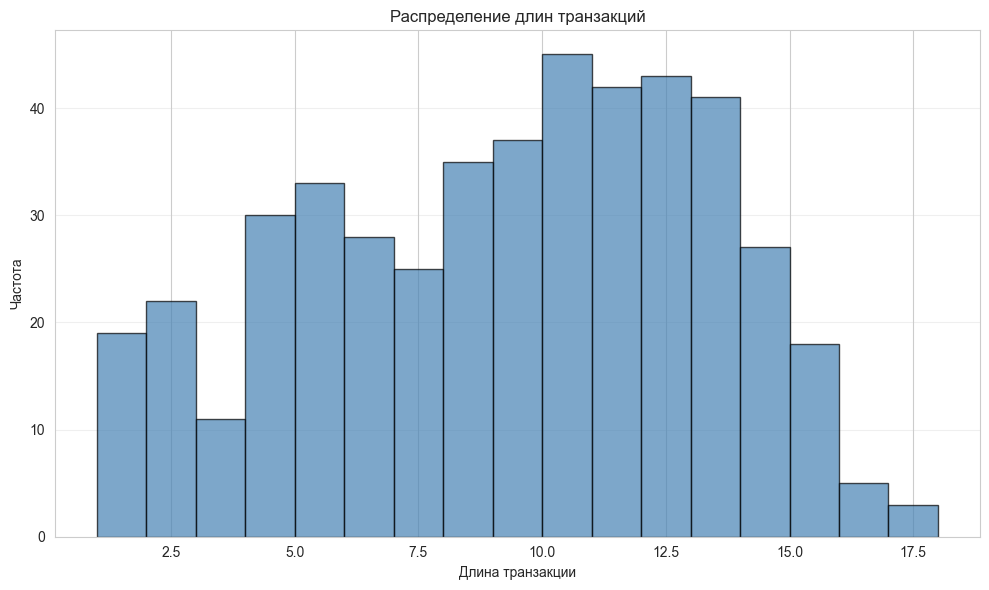

Средняя длина транзакции: 8.79
Медианная длина транзакции: 9.00
Минимальная длина транзакции: 1
Максимальная длина транзакции: 17


In [4]:
# Анализ транзакций: распределение длин транзакций
transaction_lengths = [len(t) for t in transactions]

plt.figure(figsize=(10, 6))
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2), 
         edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
photos_path = os.path.join(photos_dir, 'transaction_lengths.png')
plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
plt.show()

print(f"Средняя длина транзакции: {np.mean(transaction_lengths):.2f}")
print(f"Медианная длина транзакции: {np.median(transaction_lengths):.2f}")
print(f"Минимальная длина транзакции: {min(transaction_lengths)}")
print(f"Максимальная длина транзакции: {max(transaction_lengths)}")


In [5]:
# Список уникальных товаров
unique_items = set()
for transaction in transactions:
    unique_items.update(transaction)

print(f"Количество уникальных товаров: {len(unique_items)}")
print(f"\nПримеры товаров (первые 20):")
for i, item in enumerate(sorted(unique_items)[:20]):
    print(f"  {i+1}. {item}")


Количество уникальных товаров: 22

Примеры товаров (первые 20):
  1. Apple
  2. Bacon
  3. Banana
  4. Bread
  5. Butter
  6. Carrot
  7. Cheese
  8. Cucumber
  9. Egg
  10. Flour
  11. Hazelnut
  12. HeavyCream
  13. Honey
  14. Meat
  15. Milk
  16. Olive
  17. Onion
  18. Salt
  19. Shampoo
  20. ShavingFoam


In [6]:
# Преобразуем значения в булевы для работы с mlxtend 
data = df.astype(bool)

print(f"Бинарная матрица: {data.shape}")
print(f"Количество транзакций: {data.shape[0]}")
print(f"Количество уникальных товаров: {data.shape[1]}")
data.head()


Бинарная матрица: (464, 22)
Количество транзакций: 464
Количество уникальных товаров: 22


,Bread,Honey,Bacon,Toothpaste,Banana,Apple,Hazelnut,Cheese,Meat,Carrot,...,Milk,Butter,ShavingFoam,Salt,Flour,HeavyCream,Egg,Olive,Shampoo,Sugar
0,True,False,True,False,True,True,True,False,False,True,...,False,False,False,False,False,True,True,False,False,True
1,True,True,True,False,True,True,True,False,False,False,...,True,True,False,False,True,False,False,True,True,False
2,False,True,True,True,True,True,True,True,True,False,...,True,False,True,True,True,True,True,False,False,True
3,True,True,False,True,False,True,False,False,False,False,...,True,False,False,False,True,False,True,True,True,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Ход работы


### Алгоритм Apriori

In [7]:
# Поиск частых наборов алгоритмом Apriori
print("\n" + "="*60)
print("АЛГОРИТМ APRIORI")
print("="*60)

frequent_itemsets_ap = apriori(data, min_support=MIN_SUPPORT, use_colnames=True)
print(f"Найдено частых наборов: {len(frequent_itemsets_ap)}")
print(f"\nПервые 10 частых наборов:")
frequent_itemsets_ap.head(10)



АЛГОРИТМ APRIORI
Найдено частых наборов: 3595

Первые 10 частых наборов:


,support,itemsets
0,0.407328,(Bread)
1,0.415948,(Honey)
2,0.431034,(Bacon)
3,0.383621,(Toothpaste)
4,0.448276,(Banana)
5,0.405172,(Apple)
6,0.420259,(Hazelnut)
7,0.443966,(Cheese)
8,0.387931,(Meat)
9,0.413793,(Carrot)


In [8]:
# Генерация ассоциативных правил для Apriori
rules_ap = association_rules(frequent_itemsets_ap, metric='confidence', min_threshold=MIN_CONFIDENCE)
print(f"Найдено правил: {len(rules_ap)}")

if len(rules_ap) > 0:
    print(f"\nТоп-10 правил по лифту:")
    top_lift_ap = rules_ap.nlargest(10, 'lift')
    print(top_lift_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string())
    
    print(f"\nТоп-10 правил по достоверности:")
    top_confidence_ap = rules_ap.nlargest(10, 'confidence')
    print(top_confidence_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string())
else:
    print("Правила не найдены")


Найдено правил: 12157

Топ-10 правил по лифту:
                         antecedents            consequents   support  confidence      lift
12009          (Honey, Bacon, Onion)         (Meat, Carrot)  0.053879    0.543478  3.232999
12017          (Meat, Carrot, Onion)         (Honey, Bacon)  0.053879    0.625000  3.085106
12098          (Banana, Butter, Egg)        (Bacon, Cheese)  0.053879    0.675676  3.014553
12024            (Honey, Bacon, Egg)         (Meat, Carrot)  0.056034    0.500000  2.974359
12015          (Bacon, Meat, Carrot)         (Honey, Onion)  0.053879    0.510204  2.887008
12053         (Bacon, Cheese, Onion)       (Banana, Butter)  0.051724    0.489796  2.738136
12032            (Meat, Carrot, Egg)         (Honey, Bacon)  0.056034    0.553191  2.730647
11952          (Honey, Bacon, Onion)         (Meat, Banana)  0.051724    0.521739  2.720078
12086  (Banana, Butter, ShavingFoam)        (Bacon, Cheese)  0.060345    0.608696  2.715719
12148         (Bacon, Cheese, Oni

### Алгоритм FPGrowth


In [9]:
# Поиск частых наборов алгоритмом FPGrowth
print("="*60)
print("АЛГОРИТМ FPGROWTH")
print("="*60)

frequent_itemsets_fp = fpgrowth(data, min_support=MIN_SUPPORT, use_colnames=True)
print(f"Найдено частых наборов: {len(frequent_itemsets_fp)}")
print(f"\nПервые 10 частых наборов:")
frequent_itemsets_fp.head(10)


АЛГОРИТМ FPGROWTH
Найдено частых наборов: 3595

Первые 10 частых наборов:


,support,itemsets
0,0.448276,(Banana)
1,0.431034,(Bacon)
2,0.420259,(Hazelnut)
3,0.415948,(HeavyCream)
4,0.413793,(Carrot)
5,0.407328,(Bread)
6,0.405172,(Apple)
7,0.403017,(Egg)
8,0.366379,(Sugar)
9,0.415948,(Honey)


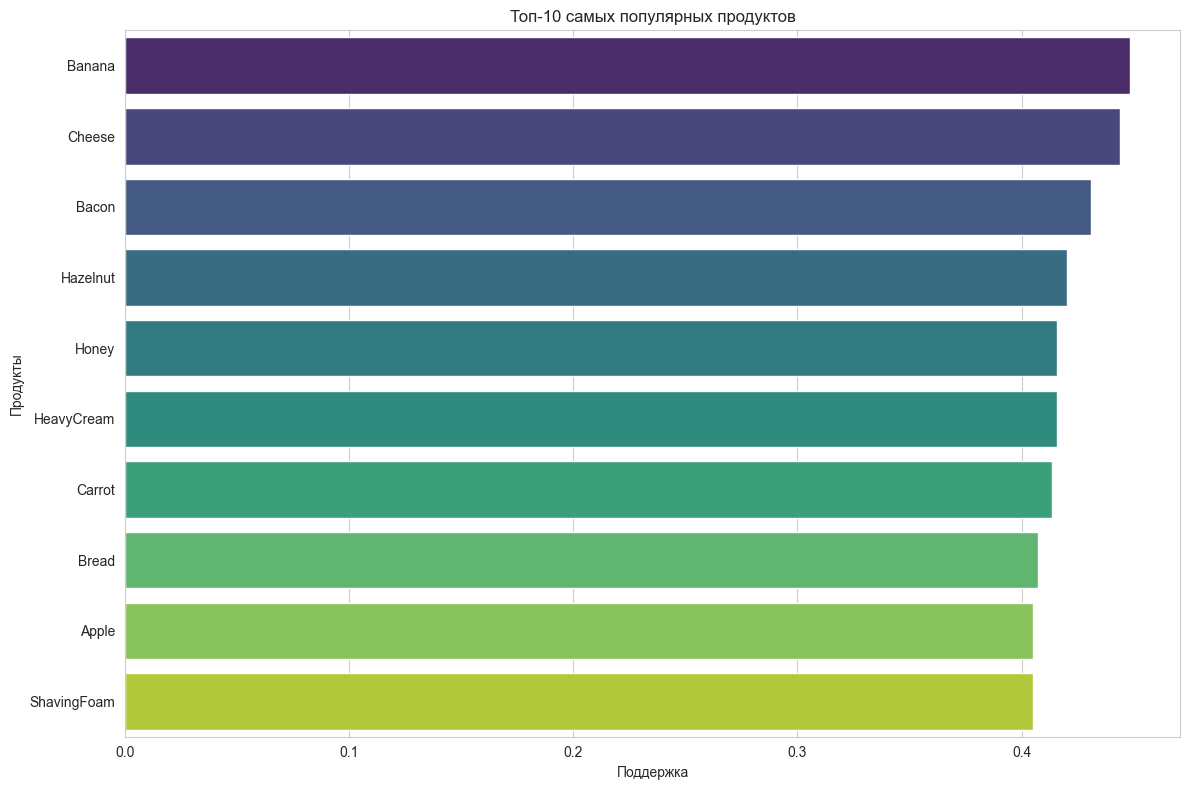

In [10]:
# Визуализация топ продуктов
df_viz = frequent_itemsets_fp.copy()
df_viz['itemsets'] = df_viz['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df_viz.sort_values(by='support', ascending=False).head(TOP_PRODUCTS_COUNT)

plt.figure(figsize=(12, 8))
sns.barplot(x='support', y='itemsets', data=top_products, hue='itemsets', legend=False, palette='viridis')
plt.title(f'Топ-{TOP_PRODUCTS_COUNT} самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
photos_path = os.path.join(photos_dir, 'top_products.png')
plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
plt.show()


In [11]:
# Генерация ассоциативных правил
rules_fp = association_rules(frequent_itemsets_fp, metric='confidence', min_threshold=MIN_CONFIDENCE)
print(f"Найдено правил: {len(rules_fp)}")

if len(rules_fp) > 0:
    print(f"\nТоп-10 правил по лифту:")
    top_lift = rules_fp.nlargest(10, 'lift')
    print(top_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string())
    
    print(f"\nТоп-10 правил по достоверности:")
    top_confidence = rules_fp.nlargest(10, 'confidence')
    print(top_confidence[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string())
    
    # Анализ тривиальных правил
    high_confidence_low_lift = rules_fp[(rules_fp['confidence'] > 0.7) & (rules_fp['lift'] < 1.2)]
    print(f"\nПравила с высокой достоверностью, но низким лифтом (возможно тривиальные): {len(high_confidence_low_lift)}")
else:
    print("Правила не найдены")


Найдено правил: 12157

Топ-10 правил по лифту:
                         antecedents            consequents   support  confidence      lift
11509          (Honey, Bacon, Onion)         (Meat, Carrot)  0.053879    0.543478  3.232999
11517          (Meat, Carrot, Onion)         (Honey, Bacon)  0.053879    0.625000  3.085106
5805           (Banana, Butter, Egg)        (Bacon, Cheese)  0.053879    0.675676  3.014553
9776             (Honey, Bacon, Egg)         (Meat, Carrot)  0.056034    0.500000  2.974359
11515          (Bacon, Meat, Carrot)         (Honey, Onion)  0.053879    0.510204  2.887008
4948          (Bacon, Cheese, Onion)       (Banana, Butter)  0.051724    0.489796  2.738136
9784             (Meat, Carrot, Egg)         (Honey, Bacon)  0.056034    0.553191  2.730647
11496          (Honey, Bacon, Onion)         (Meat, Banana)  0.051724    0.521739  2.720078
4924   (Banana, Butter, ShavingFoam)        (Bacon, Cheese)  0.060345    0.608696  2.715719
5428          (Bacon, Cheese, Oni

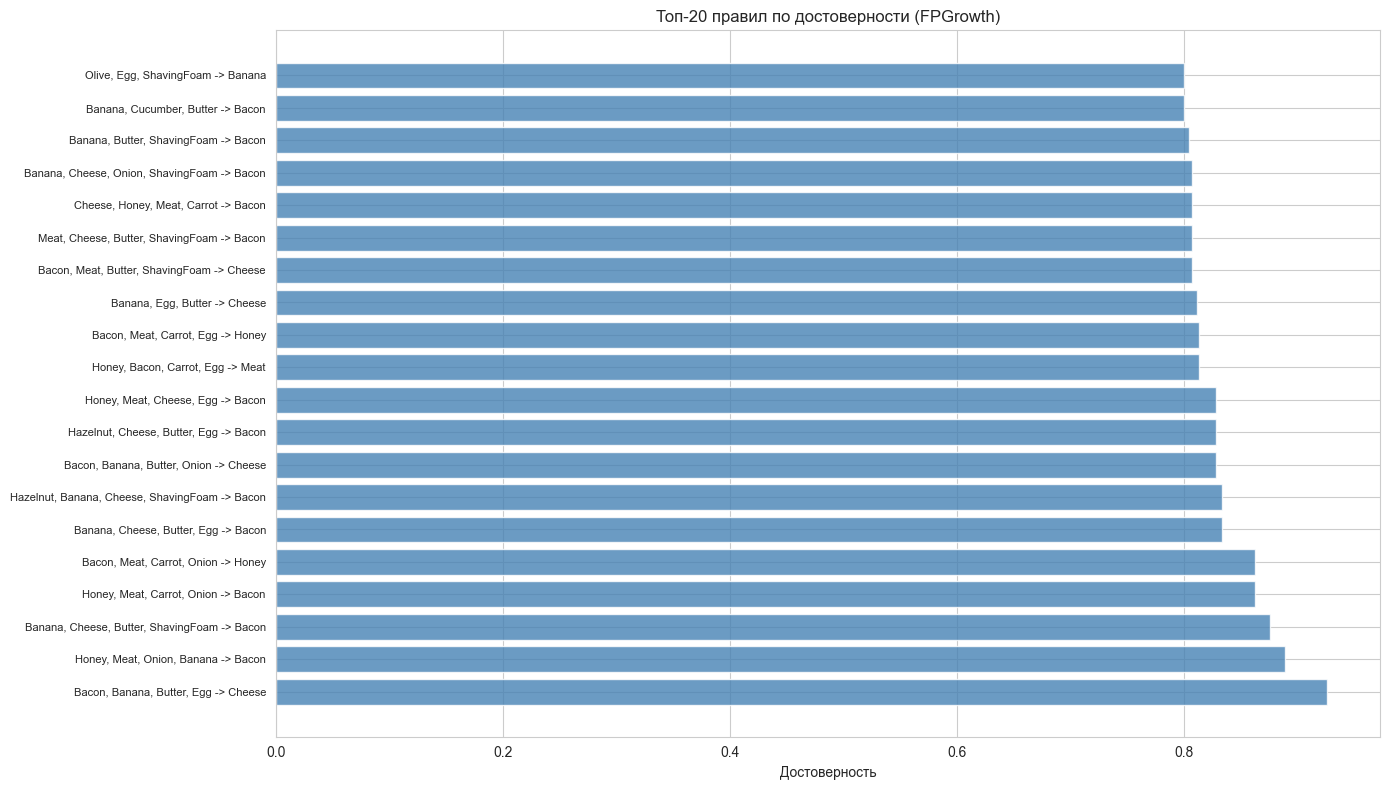

In [12]:
# Визуализация достоверности правил
if len(rules_fp) > 0:
    # Берем только топ правила
    top_rules_for_viz = rules_fp.nlargest(MAX_RULES_FOR_VIZ, 'confidence')
    
    rules_viz = top_rules_for_viz.copy()
    rules_viz['antecedents'] = rules_viz['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules_viz['consequents'] = rules_viz['consequents'].apply(lambda x: ', '.join(list(x)))
    rules_viz['rule'] = rules_viz['antecedents'] + ' -> ' + rules_viz['consequents']
    
    # Ограничиваем количество для визуализации
    top_rules = rules_viz.nlargest(20, 'confidence')
    
    plt.figure(figsize=(14, 8))
    plt.barh(range(len(top_rules)), top_rules['confidence'], color='steelblue', alpha=0.8)
    plt.yticks(range(len(top_rules)), top_rules['rule'], fontsize=8)
    plt.xlabel('Достоверность')
    plt.title('Топ-20 правил по достоверности (FPGrowth)')
    plt.tight_layout()
    photos_path = os.path.join(photos_dir, 'rules_confidence_fp.png')
    plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
    plt.show()


### Визуализация ассоциативных правил в виде графа

Сетевой граф ассоциативных правил представляет собой визуализацию, где узлы графа соответствуют товарам или наборам товаров, а ребра между узлами показывают наличие ассоциативного правила между ними. Толщина ребра или его вес может отражать метрику правила, такую как достоверность или лифт. Такой граф позволяет визуально оценить структуру взаимосвязей между товарами и выявить наиболее важные ассоциации.

Граф помогает понять, какие товары чаще всего покупаются вместе, какие товары являются центральными в структуре покупок, и какие правила наиболее значимы. Анализ графа может выявить кластеры товаров, которые часто покупаются вместе, что может быть полезно для разработки стратегий размещения товаров в магазине или рекомендательных систем.



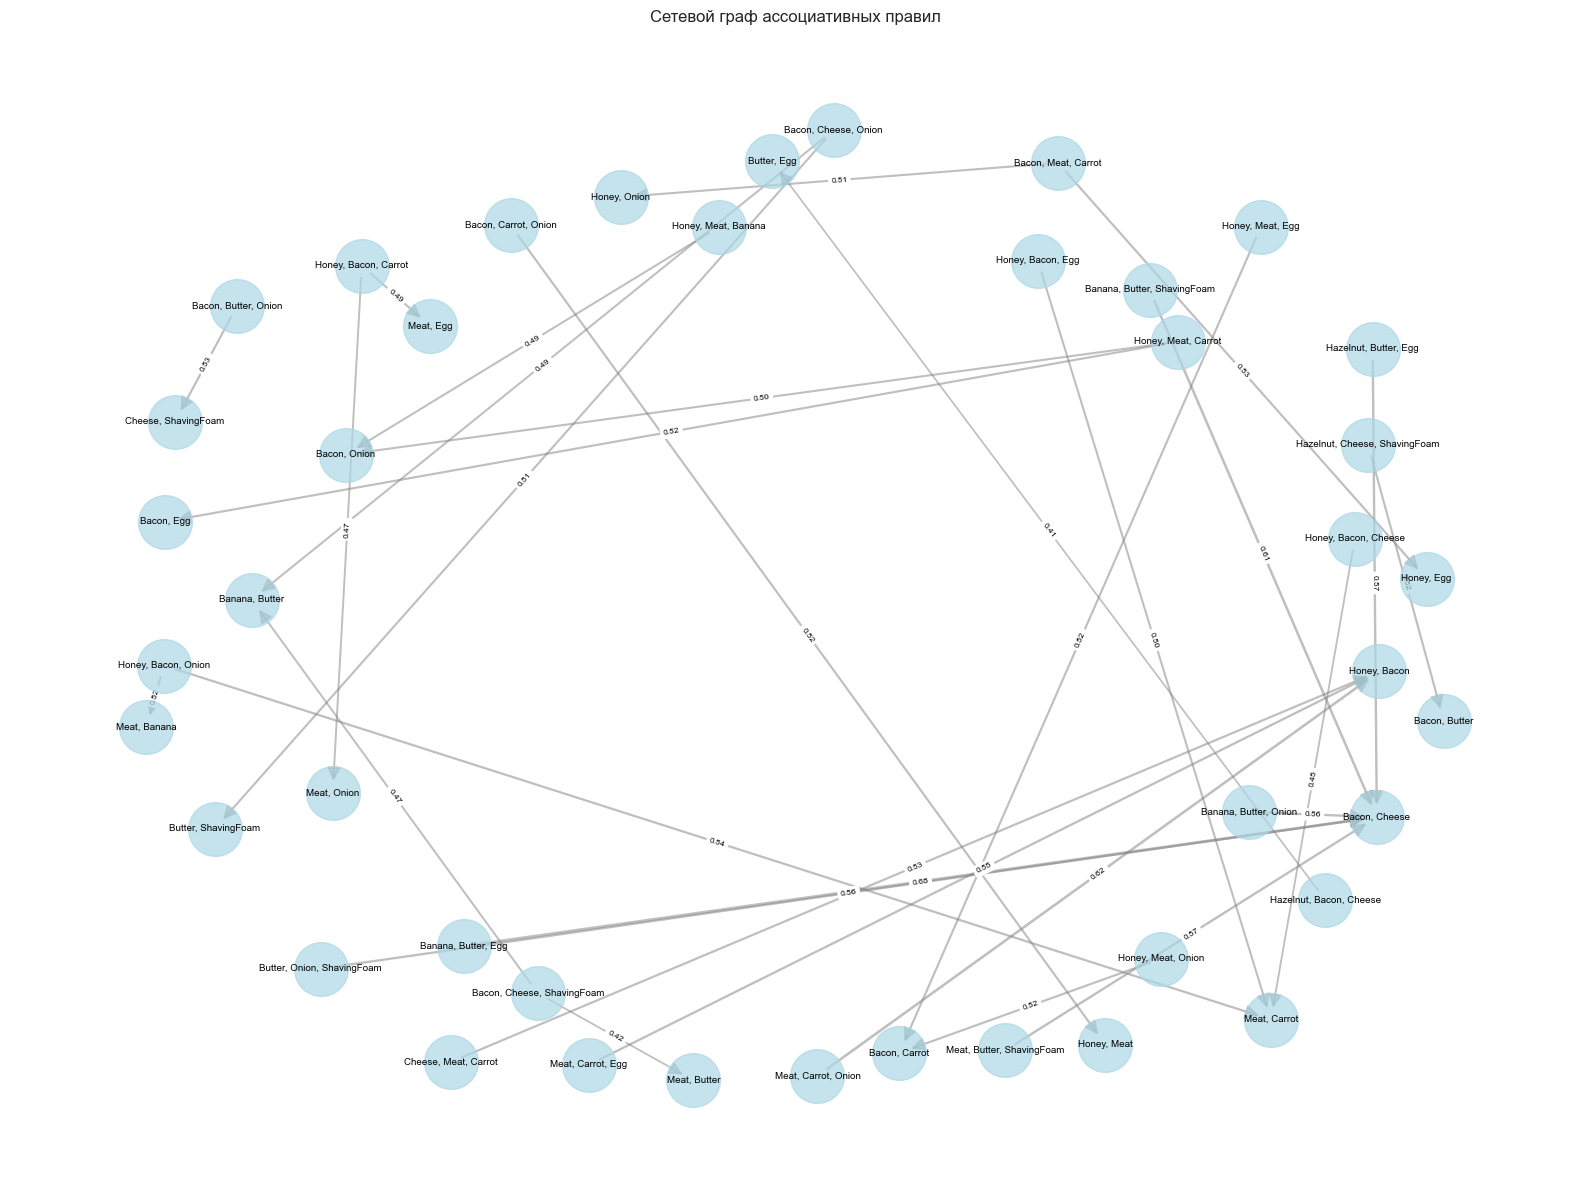

In [13]:
# Визуализация правил в виде графа
# Ограничиваем количество правил ДО итерации для быстрой работы
if len(rules_fp) > 0:
    # Берем только топ правила для визуализации
    top_rules = rules_fp.nlargest(MAX_RULES_FOR_VIZ, 'lift')
    
    G = nx.DiGraph()
    for idx, row in top_rules.iterrows():
        ant = ', '.join(list(row['antecedents']))
        cons = ', '.join(list(row['consequents']))
        G.add_edge(ant, cons, weight=row['confidence'], lift=row['lift'])
    
    if len(G.nodes()) > 0:
        # Дополнительно ограничиваем для читаемости графа
        if len(G.nodes()) > 30:
            top_rules_small = top_rules.nlargest(30, 'lift')
            G = nx.DiGraph()
            for idx, row in top_rules_small.iterrows():
                ant = ', '.join(list(row['antecedents']))
                cons = ', '.join(list(row['consequents']))
                G.add_edge(ant, cons, weight=row['confidence'], lift=row['lift'])
        
        pos = nx.spring_layout(G, k=1, iterations=30)  # Уменьшено количество итераций
        
        plt.figure(figsize=(16, 12))
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500, alpha=0.7)
        nx.draw_networkx_labels(G, pos, font_size=7)
        
        edges = G.edges()
        weights = [G[u][v]['weight'] for u, v in edges]
        nx.draw_networkx_edges(G, pos, width=[w*3 for w in weights], 
                              alpha=0.5, edge_color='gray', arrows=True, arrowsize=20)
        
        edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in edges}
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)
        
        plt.title('Сетевой граф ассоциативных правил')
        plt.axis('off')
        plt.tight_layout()
        photos_path = os.path.join(photos_dir, 'rules_graph.png')
        plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
        plt.show()


### Собственная визуализация ассоциативных правил

Для более глубокого анализа ассоциативных правил была разработана собственная визуализация, которая одновременно отображает три важные метрики: достоверность, лифт и поддержку. Визуализация представляет собой диаграмму рассеивания, где по оси X откладывается достоверность правила, по оси Y - лифт, а размер точки пропорционален поддержке правила. Цвет точки также может отражать значение поддержки, что позволяет быстро идентифицировать наиболее значимые правила.

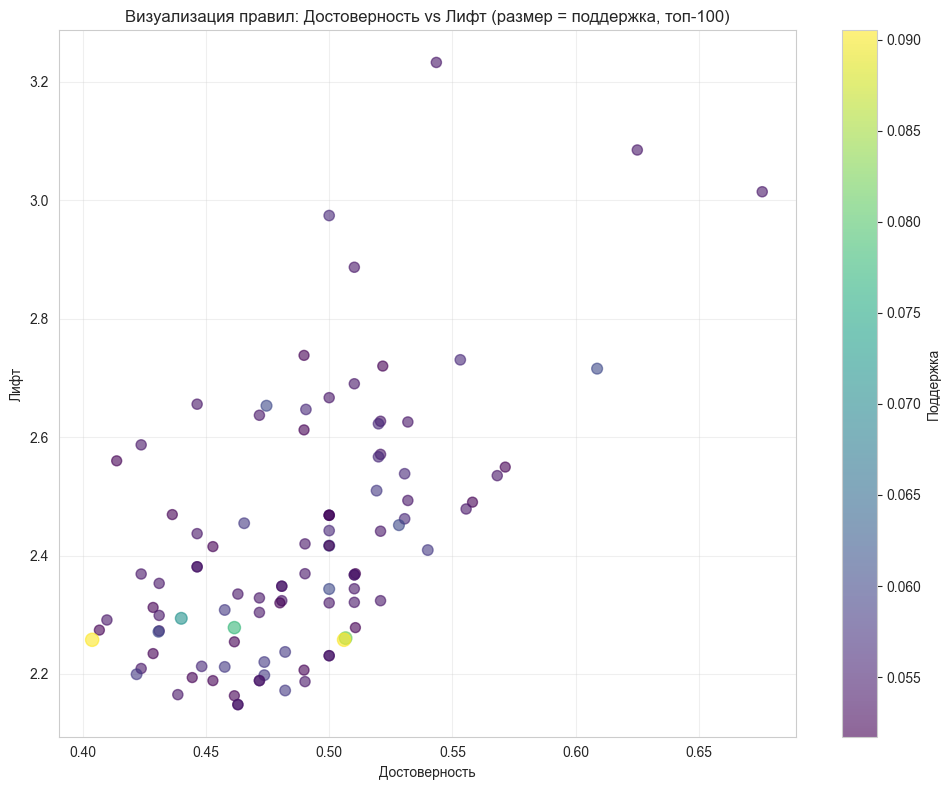

In [ ]:
# Собственная визуализация правил
if len(rules_fp) > 0:
    # Берем только топ правила для визуализации
    top_rules_viz = rules_fp.nlargest(MAX_RULES_FOR_VIZ, 'lift')
    
    plt.figure(figsize=(10, 8))
    plt.scatter(top_rules_viz['confidence'], top_rules_viz['lift'], 
               s=top_rules_viz['support']*1000, alpha=0.6, c=top_rules_viz['support'], cmap='viridis')
    plt.colorbar(label='Поддержка')
    plt.xlabel('Достоверность')
    plt.ylabel('Лифт')
    plt.title(f'Визуализация правил: Достоверность vs Лифт (размер = поддержка, топ-{MAX_RULES_FOR_VIZ})')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    photos_path = os.path.join(photos_dir, 'custom_visualization.png')
    plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
    plt.show()


### Определение минимальных значений поддержки для наборов разной длины


ОПРЕДЕЛЕНИЕ МИНИМАЛЬНОЙ ПОДДЕРЖКИ

Минимальная поддержка для наборов разной длины:
itemset_length     1      2       3       4        5       6      7    8
min_support                                                             
0.02            22.0  231.0  1540.0  7298.0  15291.0  3332.0  141.0  2.0
0.03            22.0  231.0  1540.0  6938.0   4356.0   167.0    NaN  NaN
0.04            22.0  231.0  1540.0  4767.0    404.0     1.0    NaN  NaN
0.05            22.0  231.0  1538.0  1789.0     15.0     NaN    NaN  NaN
0.06            22.0  231.0  1528.0   572.0      1.0     NaN    NaN  NaN
0.07            22.0  231.0  1411.0    75.0      NaN     NaN    NaN  NaN
0.08            22.0  231.0  1079.0    10.0      NaN     NaN    NaN  NaN


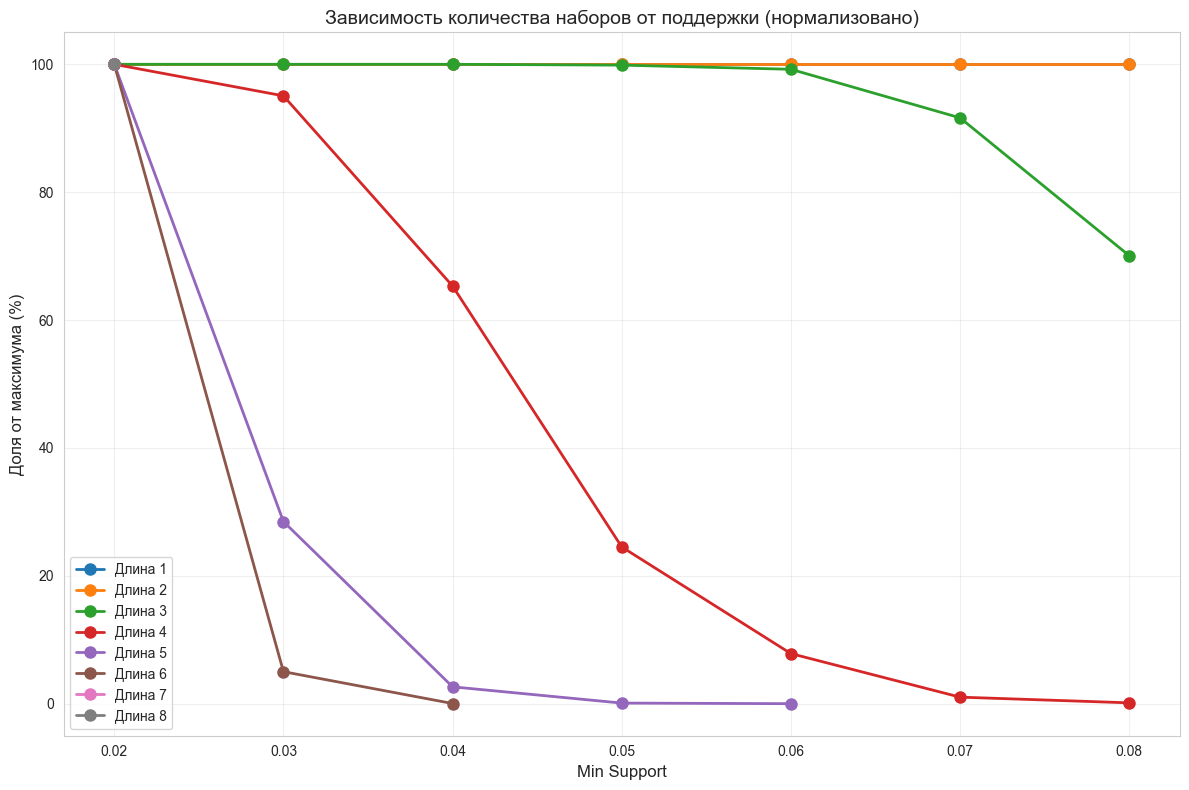

In [19]:
# Определение минимальной поддержки для наборов разной длины
print("\n" + "="*60)
print("ОПРЕДЕЛЕНИЕ МИНИМАЛЬНОЙ ПОДДЕРЖКИ")
print("="*60)

support_values = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]  
results = []

for min_support in support_values:
    frequent_itemsets = fpgrowth(data, min_support=min_support, use_colnames=True)
    
    if len(frequent_itemsets) > 0:
        itemset_lengths = frequent_itemsets['itemsets'].apply(lambda x: len(x))
        max_length = itemset_lengths.max()
        
        for length in range(1, int(max_length) + 1):
            count = (itemset_lengths == length).sum()
            if count > 0:
                results.append({
                    'min_support': min_support,
                    'itemset_length': length,
                    'count': count
                })

if results:
    results_df = pd.DataFrame(results)
    print("\nМинимальная поддержка для наборов разной длины:")
    pivot = results_df.pivot(index='min_support', columns='itemset_length', values='count')
    print(pivot.to_string())
    
    # Вычисляем максимум для каждой длины набора
    max_counts = results_df.groupby('itemset_length')['count'].max()
    
    # Добавляем нормализованные значения (относительно максимума для каждой длины)
    results_df['normalized_count'] = results_df.apply(
        lambda row: row['count'] / max_counts[row['itemset_length']], 
        axis=1
    )
    
    # Визуализация с нормализованными значениями
    plt.figure(figsize=(12, 8))
    for length in sorted(results_df['itemset_length'].unique()):
        subset = results_df[results_df['itemset_length'] == length]
        plt.plot(subset['min_support'], subset['normalized_count'] * 100, 'o-', 
                 label=f'Длина {length}', linewidth=2, markersize=8)
    plt.xlabel('Min Support', fontsize=12)
    plt.ylabel('Доля от максимума (%)', fontsize=12)
    plt.title('Зависимость количества наборов от поддержки (нормализовано)', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    photos_path = os.path.join(photos_dir, 'min_support_analysis.png')
    plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
    plt.show()


### Эксперименты с параметрами алгоритма

Для понимания влияния параметров алгоритма на получаемые правила был проведен ряд экспериментов, в которых последовательно изменялись значения поддержки и достоверности. При изменении минимальной поддержки анализировалось количество найденных частых наборов и сгенерированных правил, а также средние значения метрик достоверности и лифта.

Результаты экспериментов показывают, что уменьшение минимальной поддержки приводит к увеличению количества найденных частых наборов и правил, однако это также может привести к появлению менее значимых правил с низкой поддержкой. Увеличение минимальной поддержки, наоборот, сокращает количество правил, но оставляет только наиболее частые и потенциально более значимые ассоциации.

Аналогично, изменение минимальной достоверности влияет на количество и качество генерируемых правил. Высокие значения достоверности оставляют только правила с высокой вероятностью следствия при наличии посылки, но могут исключить полезные правила с умеренной достоверностью. Низкие значения достоверности могут привести к появлению правил со слабой связью между посылкой и следствием.


In [16]:
# Эксперименты с параметрами
print("\n" + "="*60)
print("ЭКСПЕРИМЕНТЫ С ПАРАМЕТРАМИ")
print("="*60)

experiment_results = []

for min_support in SUPPORT_VALUES:
    frequent_itemsets = fpgrowth(data, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, min_threshold=MIN_CONFIDENCE)
    
    experiment_results.append({
        'min_support': min_support,
        'frequent_itemsets': len(frequent_itemsets),
        'rules': len(rules),
        'avg_confidence': rules['confidence'].mean() if len(rules) > 0 else 0,
        'avg_lift': rules['lift'].mean() if len(rules) > 0 else 0
    })

results_df = pd.DataFrame(experiment_results)
print("\nВлияние min_support:")
print(results_df.to_string(index=False))



ЭКСПЕРИМЕНТЫ С ПАРАМЕТРАМИ

Влияние min_support:
 min_support  frequent_itemsets  rules  avg_confidence  avg_lift
        0.03              13254  61447        0.545589  1.506454
        0.04               6965  27662        0.531869  1.401553
        0.05               3595  12157        0.540225  1.353023
        0.06               2354   7096        0.526724  1.312722
        0.07               1739   4894        0.502010  1.259292


In [20]:
# Эксперимент с достоверностью (confidence)
print("\n" + "="*60)
print("ЭКСПЕРИМЕНТ С ДОСТОВЕРНОСТЬЮ")
print("="*60)

# Используем фиксированное значение поддержки для эксперимента с достоверностью
FIXED_SUPPORT = MIN_SUPPORT  # 0.05

confidence_experiment_results = []

for min_confidence in CONFIDENCE_VALUES:
    # Сначала находим частые наборы с фиксированной поддержкой
    frequent_itemsets = fpgrowth(data, min_support=FIXED_SUPPORT, use_colnames=True)
    # Затем генерируем правила с разными порогами достоверности
    rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)
    
    confidence_experiment_results.append({
        'min_confidence': min_confidence,
        'frequent_itemsets': len(frequent_itemsets),  # Количество частых наборов не меняется
        'rules': len(rules),
        'avg_confidence': rules['confidence'].mean() if len(rules) > 0 else 0,
        'avg_lift': rules['lift'].mean() if len(rules) > 0 else 0,
        'avg_support': rules['support'].mean() if len(rules) > 0 else 0
    })

confidence_results_df = pd.DataFrame(confidence_experiment_results)
print("\nВлияние min_confidence (при min_support = {}):".format(FIXED_SUPPORT))
print(confidence_results_df.to_string(index=False))



ЭКСПЕРИМЕНТ С ДОСТОВЕРНОСТЬЮ

Влияние min_confidence (при min_support = 0.05):
 min_confidence  frequent_itemsets  rules  avg_confidence  avg_lift  avg_support
            0.2               3595  26769        0.401253  1.420484     0.069766
            0.3               3595  17447        0.476897  1.428963     0.070190
            0.4               3595  12157        0.540225  1.353023     0.073625
            0.5               3595   8578        0.574788  1.411737     0.068374
            0.6               3595   2600        0.644026  1.542244     0.062904


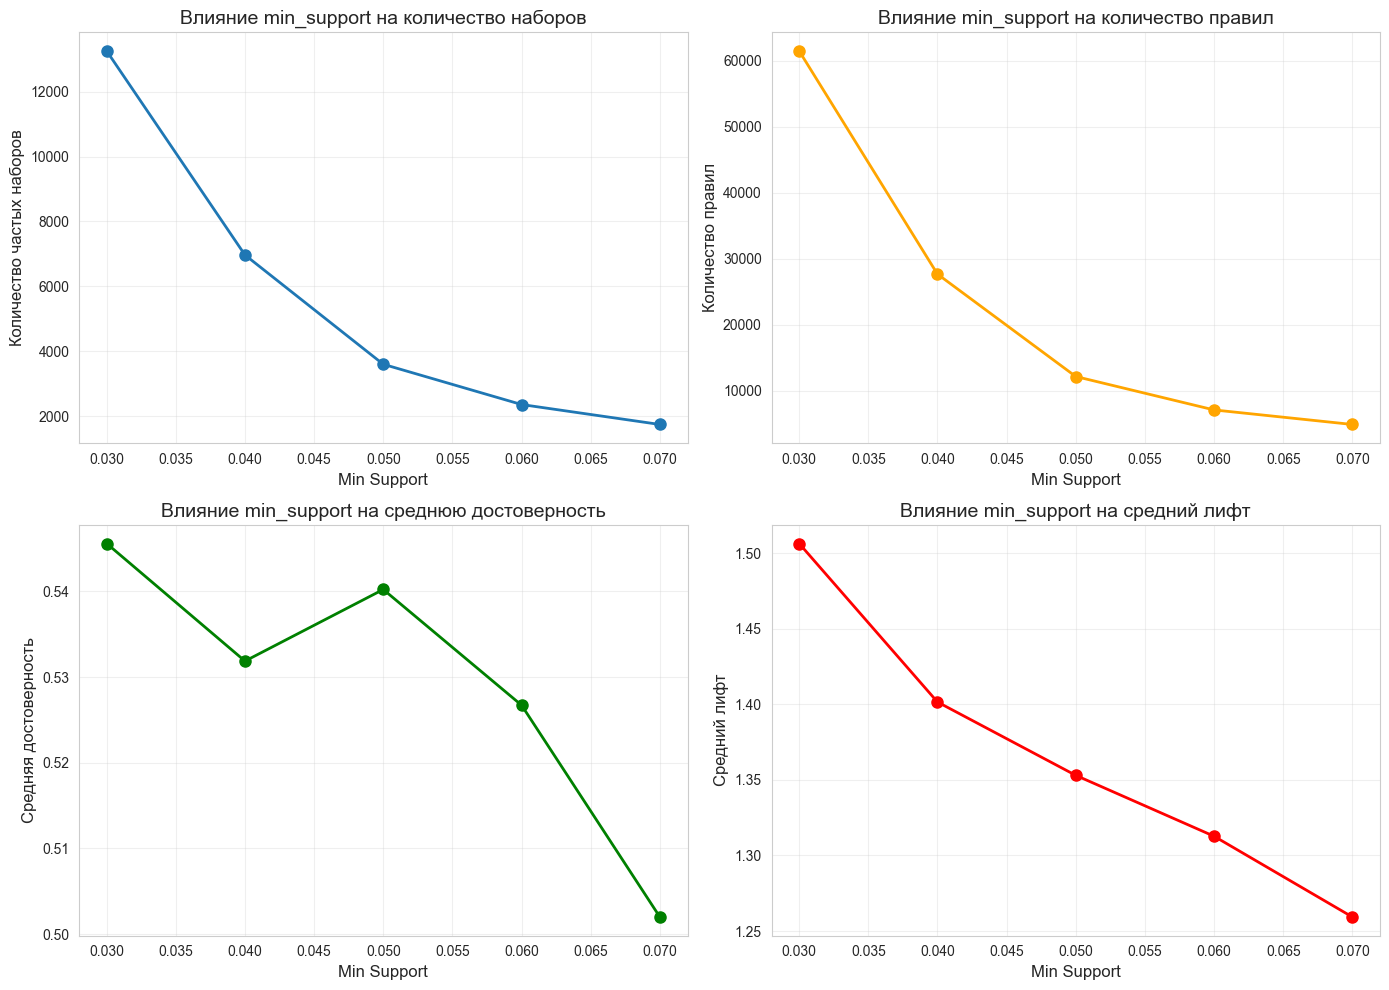

In [17]:
# Визуализация экспериментов
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(results_df['min_support'], results_df['frequent_itemsets'], 'o-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Min Support', fontsize=12)
axes[0, 0].set_ylabel('Количество частых наборов', fontsize=12)
axes[0, 0].set_title('Влияние min_support на количество наборов', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(results_df['min_support'], results_df['rules'], 'o-', color='orange', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Min Support', fontsize=12)
axes[0, 1].set_ylabel('Количество правил', fontsize=12)
axes[0, 1].set_title('Влияние min_support на количество правил', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(results_df['min_support'], results_df['avg_confidence'], 'o-', color='green', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Min Support', fontsize=12)
axes[1, 0].set_ylabel('Средняя достоверность', fontsize=12)
axes[1, 0].set_title('Влияние min_support на среднюю достоверность', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(results_df['min_support'], results_df['avg_lift'], 'o-', color='red', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Min Support', fontsize=12)
axes[1, 1].set_ylabel('Средний лифт', fontsize=12)
axes[1, 1].set_title('Влияние min_support на средний лифт', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
photos_path = os.path.join(photos_dir, 'parameter_experiments.png')
plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
plt.show()


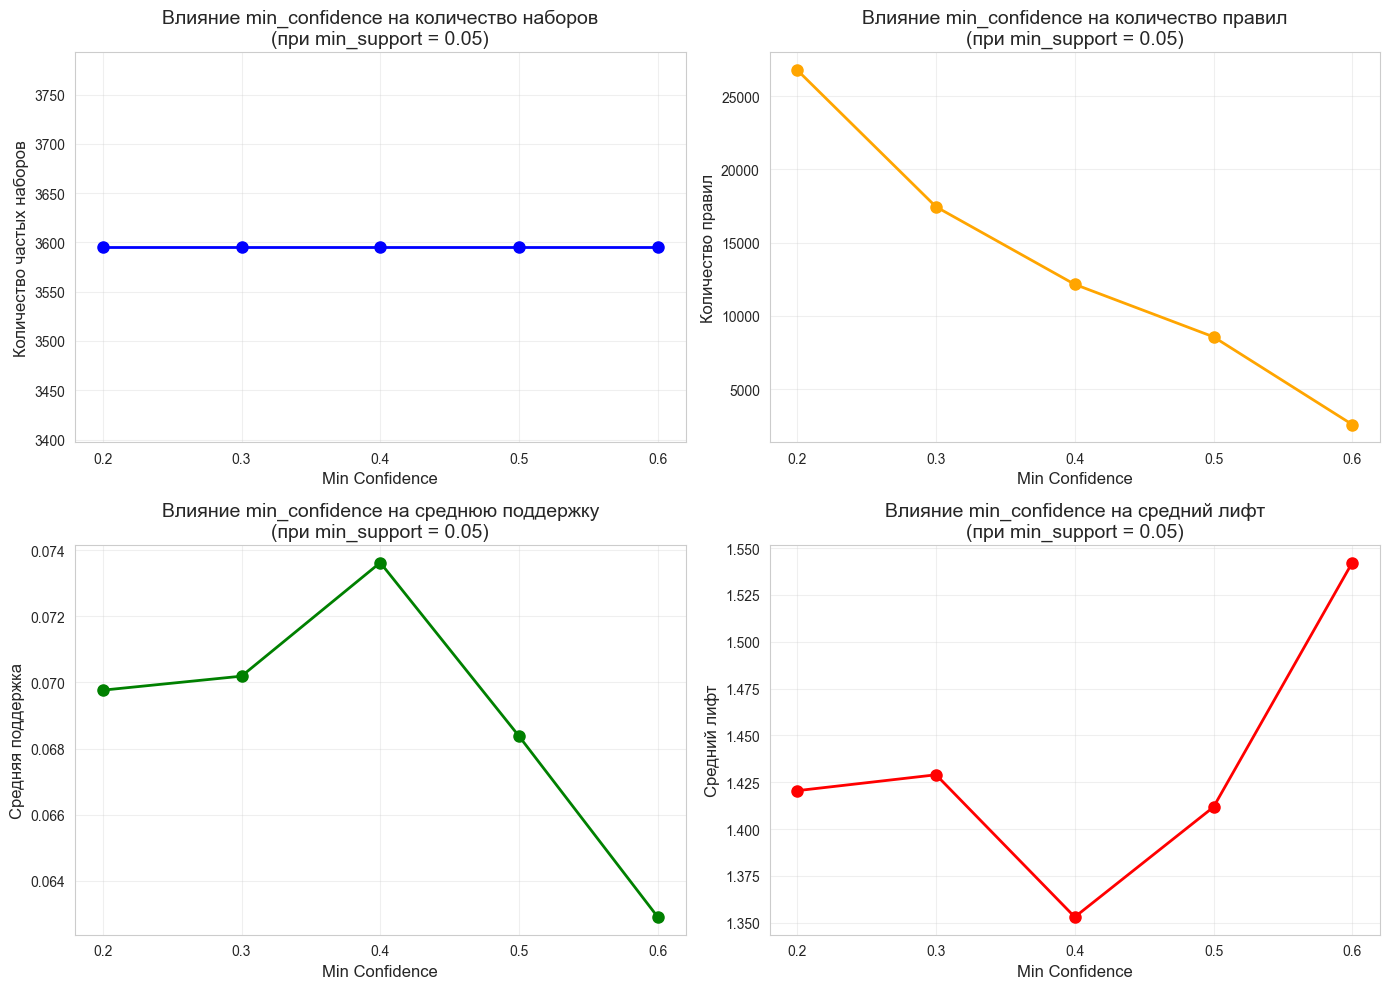

In [22]:
# Визуализация эксперимента с достоверностью
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(confidence_results_df['min_confidence'], confidence_results_df['frequent_itemsets'], 'o-', linewidth=2, markersize=8, color='blue')
axes[0, 0].set_xlabel('Min Confidence', fontsize=12)
axes[0, 0].set_ylabel('Количество частых наборов', fontsize=12)
axes[0, 0].set_title('Влияние min_confidence на количество наборов\n(при min_support = {})'.format(FIXED_SUPPORT), fontsize=14)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(confidence_results_df['min_confidence'])

axes[0, 1].plot(confidence_results_df['min_confidence'], confidence_results_df['rules'], 'o-', color='orange', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Min Confidence', fontsize=12)
axes[0, 1].set_ylabel('Количество правил', fontsize=12)
axes[0, 1].set_title('Влияние min_confidence на количество правил\n(при min_support = {})'.format(FIXED_SUPPORT), fontsize=14)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(confidence_results_df['min_confidence'])

axes[1, 0].plot(confidence_results_df['min_confidence'], confidence_results_df['avg_support'], 'o-', color='green', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Min Confidence', fontsize=12)
axes[1, 0].set_ylabel('Средняя поддержка', fontsize=12)
axes[1, 0].set_title('Влияние min_confidence на среднюю поддержку\n(при min_support = {})'.format(FIXED_SUPPORT), fontsize=14)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(confidence_results_df['min_confidence'])

axes[1, 1].plot(confidence_results_df['min_confidence'], confidence_results_df['avg_lift'], 'o-', color='red', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Min Confidence', fontsize=12)
axes[1, 1].set_ylabel('Средний лифт', fontsize=12)
axes[1, 1].set_title('Влияние min_confidence на средний лифт\n(при min_support = {})'.format(FIXED_SUPPORT), fontsize=14)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(confidence_results_df['min_confidence'])

plt.tight_layout()
photos_path = os.path.join(photos_dir, 'confidence_experiments.png')
plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
plt.show()


## Заключение

В ходе выполнения лабораторной работы был проведен полный анализ ассоциативных правил на датасете рыночной корзины. Были реализованы и протестированы два алгоритма поиска частых наборов элементов: Apriori и FPGrowth. Проведен анализ влияния параметров алгоритмов на количество и качество получаемых правил, разработана собственная визуализация для анализа метрик правил.

Результаты работы показали, что алгоритм FPGrowth является более эффективным для данного типа данных, так как он требует меньше проходов по базе данных и работает быстрее. Оба алгоритма нашли схожие частые наборы элементов, что подтверждает корректность их работы. Анализ правил выявил как полезные ассоциации между товарами, так и тривиальные правила с высокой достоверностью, но низким лифтом.

Эксперименты с параметрами показали, что выбор минимальной поддержки и достоверности является критически важным для получения значимых результатов. Слишком низкие значения параметров приводят к большому количеству правил, многие из которых могут быть незначимыми, в то время как слишком высокие значения могут исключить полезные ассоциации.

Визуализация правил в виде графа и разработанная собственная визуализация метрик позволили наглядно представить структуру взаимосвязей между товарами и выявить наиболее значимые правила. Полученные результаты могут быть использованы для разработки рекомендательных систем, оптимизации размещения товаров в магазине и разработки маркетинговых стратегий.


## Список источников

1. Scikit-learn: Machine Learning in Python. URL: https://scikit-learn.org/stable/

2. Pandas: Python Data Analysis Library. URL: https://pandas.pydata.org/

3. NumPy: The fundamental package for scientific computing with Python. URL: https://numpy.org/

4. Matplotlib: Visualization with Python. URL: https://matplotlib.org/

5. Seaborn: Statistical data visualization. URL: https://seaborn.pydata.org/

6. MLxtend: Machine Learning Extensions. URL: https://rasbt.github.io/mlxtend/

7. NetworkX: Network Analysis in Python. URL: https://networkx.org/

8. Agrawal, R., Imieliński, T., & Swami, A. (1993). Mining association rules between sets of items in large databases. Proceedings of the 1993 ACM SIGMOD international conference on Management of data, 207-216.

9. Han, J., Pei, J., & Yin, Y. (2000). Mining frequent patterns without candidate generation. Proceedings of the 2000 ACM SIGMOD international conference on Management of data, 1-12.

10. Kaggle: Your Machine Learning and Data Science Community. URL: https://www.kaggle.com/
